<div style="background-color: #ffffff; color: #333; padding: 15px; border: 1px solid #ddd; border-radius: 8px;">
    <a class="anchor" id="1st-bullet"></a>
    <h2 style="color: #795548; font-weight: bold; text-align: center;">Group Project - Feature Selection</h2>
    <h3 style="color: #a1887f; text-align: center;">Data Mining 2024/2025</h3>
</div>

<div style="text-align: center;">
    <strong>Group 14</strong>
    <table style="margin: 0 auto; border-collapse: collapse; border: 1px solid black;">
        <tr>
            <th style="border: 1px solid white; padding: 8px;">Name</th>
            <th style="border: 1px solid white; padding: 8px;">Student ID</th>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Francisco Santos</td>
            <td style="border: 1px solid white; padding: 8px;">20240562</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Margarida Raposo</td>
            <td style="border: 1px solid white; padding: 8px;">20241020</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Nuno Nunes</td>
            <td style="border: 1px solid white; padding: 8px;">20240560</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Teresa Menezes</td>
            <td style="border: 1px solid white; padding: 8px;">20240333</td>
        </tr>
    </table>
</div>

### **Structure**
1. [Change](#add)
2. [Change](#add)
3. Feature Engineering ? https://www.kaggle.com/code/karnikakapoor/customer-segmentation-clustering

In [2]:
import pandas as pd
import numpy as np

# import matplotlib.pyplot and seaborn for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

import os
from math import ceil

from scipy import stats

import warnings

In [3]:
df = pd.read_csv('df1.csv')

In [4]:
no_orders = df.loc[:, 'DOW_0':'DOW_6'].sum(axis=1) == 0
no_orders = df[no_orders]

In [5]:
# new dataframe with only customers who have ordered
df_customers = df[~df.index.isin(no_orders.index)]

In [6]:
df_customers.head(2)

,customer_id,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,...,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,total_amount_spent,age_group,customer_city,total_orders
0,1b8f824d5e,2360,18.0,2,5,1,0.0,1,DELIVERY,DIGI,...,2,0,0,0,0,0,28.88,0-20,2,2
1,5d272b9dcb,8670,17.0,2,2,2,0.0,1,DISCOUNT,DIGI,...,0,0,0,0,0,0,19.21,0-20,8,2


In [7]:
# set customer_id as index
df_customers.set_index('customer_id', inplace=True)

In [8]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31690 entries, 1b8f824d5e to fd40d3b0e0
Data columns (total 59 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_region           31690 non-null  object 
 1   customer_age              30963 non-null  float64
 2   vendor_count              31690 non-null  int64  
 3   product_count             31690 non-null  int64  
 4   is_chain                  31690 non-null  int64  
 5   first_order               31584 non-null  float64
 6   last_order                31690 non-null  int64  
 7   last_promo                31690 non-null  object 
 8   payment_method            31690 non-null  object 
 9   CUI_American              31690 non-null  float64
 10  CUI_Asian                 31690 non-null  float64
 11  CUI_Beverages             31690 non-null  float64
 12  CUI_Cafe                  31690 non-null  float64
 13  CUI_Chicken Dishes        31690 non-null  float64
 1

In [9]:
# get the total number of NaN values for each column
total_nan = df_customers.isna().sum().sort_values(ascending=False)

# get the percentage of NaN values for each column
percent_nan = ((total_nan / len(df_customers)) * 100).round(2)

# create a DataFrame to display the total and percentage of NaN values for each column
nan_stats = pd.DataFrame({'Total NaN': total_nan, 'Percentage NaN': percent_nan})

# no need to display columns with no NaN values
nan_stats = nan_stats[nan_stats['Total NaN'] > 0]

nan_stats

,Total NaN,Percentage NaN
HR_0,1164,3.67
customer_age,727,2.29
age_group,727,2.29
first_order,106,0.33


- Low %, so lets use imputation

- Same % for 'customer_age' and 'age_group' -> NaN values in age_group are probably due to missing values in customer_age

In [10]:
# ignore warnings
warnings.filterwarnings('ignore')

# fill HR_0 with the mean value 
hr_0_mean = df_customers['HR_0'].mean()
df_customers['HR_0'].fillna(hr_0_mean, inplace=True)
hr_0_mean

0.0

In [11]:
# Check if missing age_group aligns with missing customer_age
missing_consistency = df_customers[df_customers['customer_age'].isnull()]['age_group'].isnull().all()
print(f"Are all missing age_group values tied to missing customer_age? {missing_consistency}")

Are all missing age_group values tied to missing customer_age? True


Text(0.5, 1.0, 'Distribution of Customer Age')

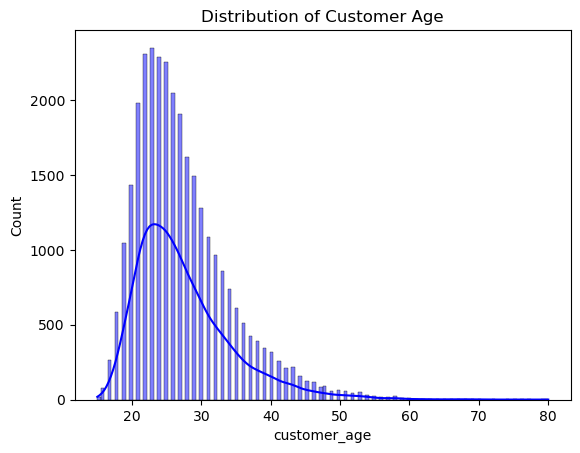

In [12]:
# get distribution of the 'customer_age' column
sns.histplot(df_customers['customer_age'], kde=True, color='blue')
plt.title('Distribution of Customer Age')


- Distribution is right-skewed, let's use the median over the mean

In [13]:
# ignore warnings
warnings.filterwarnings('ignore')

# fill customer_age with the median value
customer_age_median = df_customers['customer_age'].median()  # 26
df_customers['customer_age'].fillna(customer_age_median, inplace=True)

# fill age_group with the respective age group (21-30)
df_customers['age_group'].fillna('21-30', inplace=True)

First_Order - Impute with the mean, median or mode doesn't make sense here. As those missing values represent 0.33% let's drop them

In [14]:
# ignore warnings
warnings.filterwarnings('ignore')

# drop rows where first_order is missing
df_customers.dropna(subset=['first_order'], inplace=True)

## Outliers

In [15]:
#Dummification of categorical data
non_numerical_columns = df_customers.select_dtypes(include=['object']).columns
for i in non_numerical_columns:
    x1 = pd.get_dummies(df_customers[i])
    df1 = df_customers.join(x1,lsuffix='_l',rsuffix='_r')
    df1.drop(i,axis=1,inplace=True)

In [17]:
df1

,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,...,total_amount_spent,customer_city,total_orders,0-20,21-30,31-40,41-50,51-60,61-70,71-80
customer_id,,,,,,,,,,,,,,,,,,,,,
1b8f824d5e,2360,18.0,2,5,1,0.0,1,DELIVERY,DIGI,0.00,...,28.88,2,2,True,False,False,False,False,False,False
5d272b9dcb,8670,17.0,2,2,2,0.0,1,DISCOUNT,DIGI,12.82,...,19.21,8,2,True,False,False,False,False,False,False
f6d1b2ba63,4660,38.0,1,2,2,0.0,1,DISCOUNT,CASH,9.20,...,9.20,4,2,False,False,True,False,False,False,False
180c632ed8,4660,26.0,2,3,1,0.0,2,DELIVERY,DIGI,0.00,...,31.56,4,2,False,True,False,False,False,False,False
4eb37a6705,4660,20.0,2,5,0,0.0,2,-,DIGI,14.57,...,55.44,4,2,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eb13c834e7,2360,74.0,1,1,1,89.0,89,DELIVERY,CARD,0.00,...,1.75,2,1,False,False,False,False,False,False,True
f7be3a1a84,2440,26.0,1,1,1,89.0,89,-,CASH,0.00,...,1.86,2,1,False,True,False,False,False,False,False
fc924e1758,4660,20.0,1,2,0,89.0,89,DELIVERY,CASH,0.00,...,23.15,4,1,True,False,False,False,False,False,False


Standardizing the data is key for most of the clustering techniques to avoid a feature biasing the results of clustering

In [18]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
# import minmax scaler
from sklearn.preprocessing import MinMaxScaler

In [19]:
# new dataframe with numerical data
df_numerical = df1.select_dtypes(include=['float64', 'int64'])

In [20]:
df_num = MinMaxScaler().fit_transform(df_numerical)

In [21]:
A = []
B = []
C = []

for i in np.linspace(0.1,5,100):
    db = DBSCAN(eps=i, min_samples=10,n_jobs=-1).fit(df_num)

    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    
    sum = 0
    for t in labels:
        if t == -1: 
            sum = sum + 1
    C.append(sum)    
    A.append(i)
    B.append(int(n_clusters_))

: 

<Axes: xlabel='distance'>

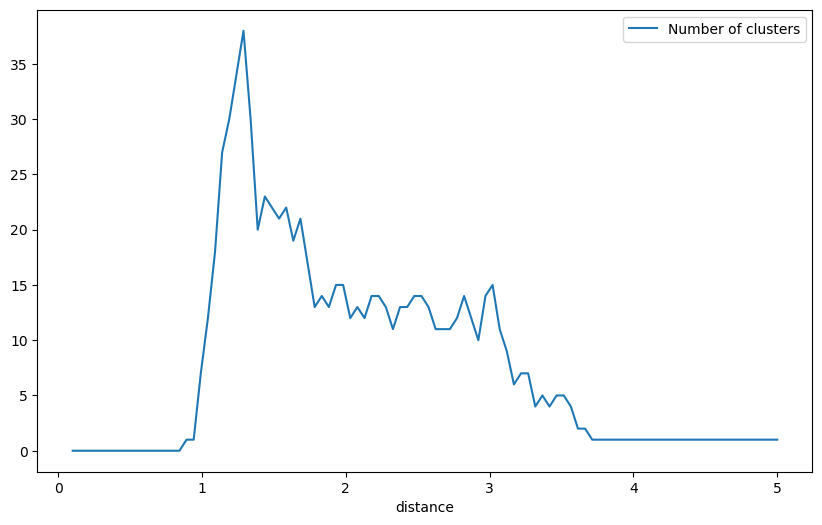

In [ ]:
results = pd.DataFrame([A,B,C]).T
results.columns = ['distance','Number of clusters','Number of outliers']
results.plot(x='distance',y='Number of clusters',figsize=(10,6))

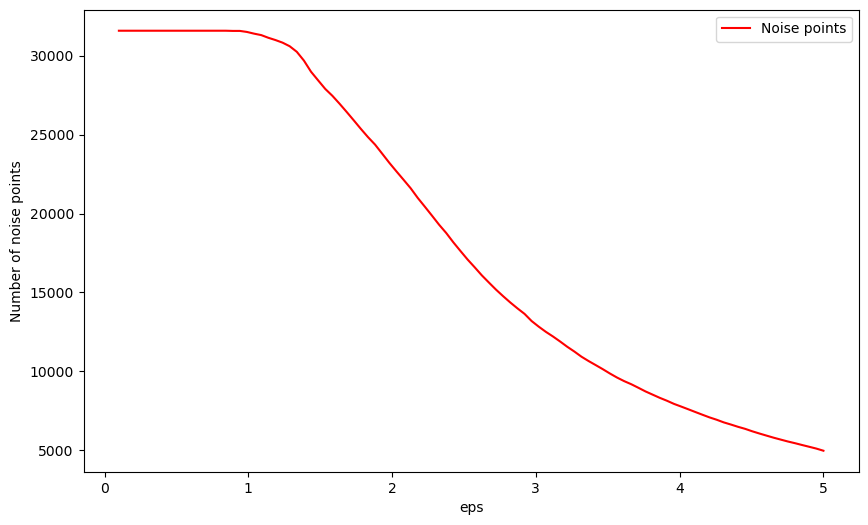

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(A, C, label='Noise points', color='red')
plt.xlabel('eps')
plt.ylabel('Number of noise points')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score

db = DBSCAN(eps=4.5, min_samples=10).fit(df_num)  # Example with eps=1.2
labels = db.labels_
if len(set(labels)) > 1:  # Silhouette score requires at least 2 clusters
    score = silhouette_score(df_num, labels)
    print(f"Silhouette Score for eps=1.0: {score}")


Silhouette Score for eps=1.0: 0.3904796068803315


In [16]:
df1.to_csv('df2.csv', index=True)